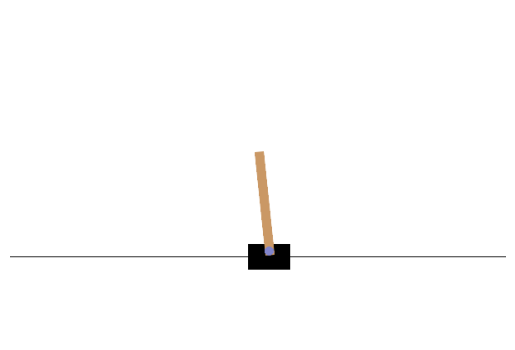

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# Define replay memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()

        if len(input_shape) == 1:  # Assuming input shape for fully connected layers
            self.fc1 = nn.Linear(input_shape[0], 128)
            self.fc2 = nn.Linear(128, 128)
            self.fc3 = nn.Linear(128, num_actions)
        elif len(input_shape) == 3:  # Assuming input shape for convolutional layers
            self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
            self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
            conv_out_size = self._get_conv_out(input_shape)
            self.fc1 = nn.Linear(conv_out_size, 512)
            self.fc2 = nn.Linear(512, num_actions)
        else:
            raise ValueError("Unsupported input shape")

    def forward(self, x):
        if hasattr(self, 'conv1'):  # Using convolutional layers
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            x = F.relu(self.fc1(x.view(x.size(0), -1)))
        else:  # Using fully connected layers
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        return x

    def _get_conv_out(self, shape):
        o = self.conv1(torch.zeros(1, *shape))
        o = self.conv2(o)
        o = self.conv3(o)
        return int(np.prod(o.size()))

# Define training function
def train_dqn(env_name, num_episodes, batch_size, gamma, eps_start, eps_end, eps_decay, target_update):
    env = gym.make(env_name)
    memory = ReplayMemory(10000)
    policy_net = DQN(env.observation_space.shape, env.action_space.n)
    target_net = DQN(env.observation_space.shape, env.action_space.n)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters())
    steps_done = 0
    rewards = []

    def select_action(state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                return policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(env.action_space.n)]], dtype=torch.long)

    def optimize_model():
        if len(memory) < batch_size:
            return
        transitions = memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        state_action_values = policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(batch_size)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * gamma) + reward_batch
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        for param in policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()
        return loss.item()

    epsilon = eps_start
    for episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor([state], dtype=torch.float32)
        total_reward = 0
        for t in range(10000):
            action = select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.tensor([next_state], dtype=torch.float32) if not done else None
            reward = torch.tensor([reward], dtype=torch.float32)
            memory.push(state, action, next_state, reward)
            state = next_state
            total_reward += reward.item()
            loss = optimize_model()
            steps_done += 1
            if done:
                rewards.append(total_reward)
                break
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if epsilon > eps_end:
            epsilon *= eps_decay

    env.close()
    return rewards

# Parameters
env_name = 'CartPole-v1'
num_episodes = 1000
batch_size = 128
gamma = 0.99
eps_start = 0.9
eps_end = 0.05
eps_decay = 0.995
target_update = 10

# Train DQN
rewards = train_dqn(env_name, num_episodes, batch_size, gamma, eps_start, eps_end, eps_decay, target_update)

#--2nd one

def play_atari(env_name, num_episodes):
    env = gym.make(env_name)
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            plt.imshow(env.render(mode='rgb_array'))
            plt.axis('off')
            clear_output(wait=True)
            display(plt.gcf())
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
    env.close()

# Call the gameplay display function
play_atari(env_name, num_episodes)